# Using flatw'rm2 from jupyter-notebook or standalone

`flatw'rm2` is a Long Short-Term Memory (LSTM) neural network to recover flares in space-borne photometric data, trained currently on short-cadence Kepler photometry. For more details on the network, see **(reference to arXiv)**
 
`flatw'rm2` can be used in different ways, either from a console, run as a script, or as a module from jupyter-notebok for testing or interactive usage. For faster predictions, we suggest to run the code on a CUDA-capable GPU, although CPUs are also supported.

For running the code on Google Colab (https://colab.research.google.com/), you need to open the notebook, then clone the GitHub repository to have the `flatwrm2` module, the weights and data file at hand. Make sure to request a GPU for your session, then change the type of the next cell from Raw to Code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import flatwrm2

Light curves can be either loaded manually, using e.g. `numpy.genfromtxt`, or file names can be directly passed to `flatw'rm2`.

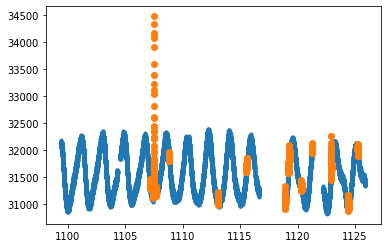

In [2]:
lc = np.genfromtxt("kplr003441906-2012032013838_slc.fits.flare").T

plt.plot(lc[0], lc[1], ".", c="C0")
plt.plot(lc[0][lc[2]==1], lc[1][lc[2]==1], "o", c="C1")

In the most basic usage case, simply provide the light curve as an array to the `prediction` function, and specify a batch number. With increasing batch numbers the calculation will be faster, but make sure the lenght of the batches remains longer than the typical time scale of flares.

The data will be interpolated to equidistant steps (one minute), and the code will return an array with the predicted flare probabilities for each data point and an array with the interpolated data and predictions as used by the network. This latter will be needed for the validation step.

In [3]:
pred, ipred = flatwrm2.prediction([lc[0], lc[1]], batch=64, GPU=0)


Using GPU 3 
597/597 [==============================] - 5s 9ms/step


Depending on the science case, the cutoff value for the probabilities could be different, ~0.9 could be used for fewer false positives, or can be lowered to even 0.2 to decrease possible false negatives.

If this level of output is already enough for your science case, if might be a good idea to pass this array through a median filter (see the paper for details) to get rid of few-point false positive detections.

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


(1107.0, 1109.0)

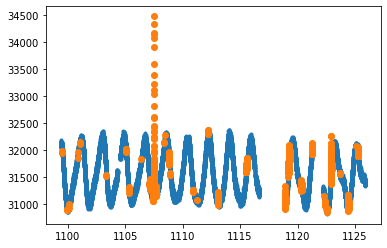

<Figure size 432x288 with 0 Axes>

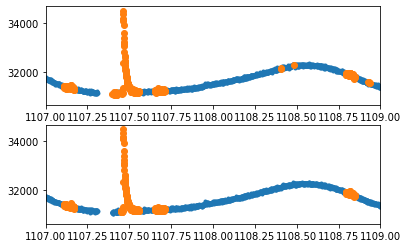

In [4]:
mask=(pred>.5)

plt.figure(0)
plt.plot(lc[0], lc[1], ".", c="C0")
plt.plot(lc[0][mask], lc[1][mask], "o", c="C1")
plt.figure(1)
f, (ax1, ax2) = plt.subplots(2)
ax1.plot(lc[0], lc[1], ".", c="C0")
ax1.plot(lc[0][mask], lc[1][mask], "o", c="C1")

import scipy.signal
mask2 = scipy.signal.medfilt(pred, kernel_size=47) >0.5
ax2.plot(lc[0], lc[1], ".", c="C0")
ax2.plot(lc[0][mask2], lc[1][mask2], "o", c="C1")
ax1.set_xlim(1107,1109)
ax2.set_xlim(1107,1109)

### Validation

For validation, i.e. fitting each flare iteratively with the model of Davenport (2016), the input must be the time, flux and the ``ipred`` output of `flatwrm2.prediction()`.

Two parameters must choosen carefully:

- __window_size__: the window size of median filter kernel used to smooth the raw LSTM predictions.
- __pred_probability_cut__: the probability threshold above which a point is consider to be a flare after the median filter smoothing.

In [5]:
flares = flatwrm2.validation( lc[0], lc[1] , ipred,
                            window_size=64,
                            pred_probability_cut=0.5,
                            progressbar=True
                        )

100%|██████████| 14/14 [00:00<00:00, 14.19it/s]


The returned parameters of detected and fitted flares are

- _t_peak_: peak time of maximum point
- _Amplitude_: amplitude of maximum point
- _t_peak_model_: peak time of flare model
- _Amplitude_model_: amplitude of flare model
- _SperN_: flare signal-to-noise ratio
- _Epsilon_: integrated flare flux in relative units
- _Duration_: flare duration in days

The lower the S/N the higher the probability of a given flare being a false detection. The rule of thumb is that above 5$\sigma$ we are good, below 5$\sigma$ the false/true detection rate rapidly increasing, and below 3$\sigma$ most of the flares are flase alarms.

In [6]:
flares

,t_peak,Amplitude,t_peak_model,Amplitude_model,SperN,Epsilon,Duration
0,1107.152563,0.004071,1107.152537,0.004662,5.234291,0.000019,0.010237
1,1107.463146,0.102066,1107.463578,0.128074,26.005728,0.001497,0.065544
2,1107.669520,0.002474,1107.669742,0.003181,3.293912,0.000018,0.012925
3,1108.818541,0.003010,1108.817594,0.003077,3.547286,0.000021,0.015494
4,1113.057739,0.004667,1113.059719,0.005005,4.410960,0.000068,0.033636
5,1115.564212,0.004975,1115.564233,0.004829,5.027255,0.000063,0.034771
6,1118.933657,0.007335,1118.933903,0.010109,9.560110,0.000039,0.012943
7,1119.198608,0.006648,1119.197375,0.006693,6.340814,0.000100,0.043680
8,1119.290558,0.008547,1119.290671,0.009061,6.319475,0.000086,0.026546
9,1119.315078,0.001469,1119.314603,0.003253,2.895640,0.000004,0.002783


Alternatively, a file can be passed to the `prediction` function, in this case, setting `save_model=True` saves the prediction to a file with `.pred` extension.

In [7]:
pred, ipred = flatwrm2.prediction("kplr003441906-2012032013838_slc.fits.flare", 
                          DEBUG=False, verbose=True, batch=64, save_model=True, GPU=0)


Using GPU 0 
Processing kplr003441906-2012032013838_slc.fits.flare
597/597 [==============================] - 5s 8ms/step


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


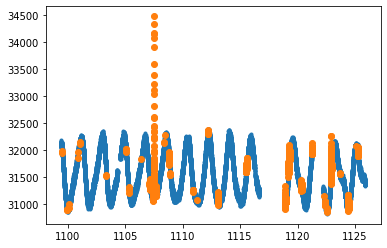

In [8]:
mask=(pred>.5)
plt.plot(lc[0], lc[1], ".", c="C0")
plt.plot(lc[0][mask], lc[1][mask], "o", c="C1")


Furthermore, you can run `flatw'rm2` from a console for non-interactive usage, e.g. scripted, in the background, using GNU `screen`.

In [9]:
!./flatwrm2.py --help

Usage: ./flatwrm2.py [options] <input file(s)>
Options:
-h, --help: print this help message
-m, --model=<weight_file>: load the specified weight file for the prediction
-b, --batch=<n>: number of batches to use simultaneously (default: 1)
--gpu=<n>: set CUDA_VISIBLE_DEVICES: forces CUDA to use the given GPU. -1 disables CPU. (default: 0)
-d, --debug: verbose mode


In [10]:
!./flatwrm2.py --batch=64 --gpu=0 -m LSTM_weights_keplerSC.h5 kplr003441906-2012032013838_slc.fits.flare

Using GPU 0 
Processing kplr003441906-2012032013838_slc.fits.flare
597/597 [==============================] - 5s 8ms/step
